In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/pareshar/.pyenv/versions/3.8.10/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Scaled dot product attention

In [2]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        
    def call(self, queries, keys, values, d_k, mask=None):
        
        scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d_k, tf.float32))
        if mask is not None:
            scores += -1e9 * mask
        weights = tf.nn.softmax(scores, axis=-1)
        return tf.matmul(weights, values)

In [3]:
# test
input_seq_length = 5  # Maximum length of the input sequence
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
batch_size = 64  # Batch size from the training process
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))
attention = ScaledDotProductAttention()
print(attention(queries, keys, values, d_k).shape)

(64, 5, 64)


2023-07-26 16:20:51.363821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Multi-head attention

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = ScaledDotProductAttention()
        self.heads = h
        self.d_k = d_k # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v # Dimensionality of the linearly projected values
        self.d_model = d_model # Dimensionality of the model
        self.W_q = tf.keras.layers.Dense(d_k) # Learned projection matrix for the queries
        self.W_k = tf.keras.layers.Dense(d_k)
        self.W_v = tf.keras.layers.Dense(d_v)
        self.W_o = tf.keras.layers.Dense(d_model) # Learned projection matrix for the multi-head output

    def reshape_tensor_to_compute_heads_in_parallel(self, x, heads, flag):
        if flag:
            # reshaping input: (batch_size, seq_length, d_k)
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1)) # (batch_size, seq_length, heads, depth)
            x = tf.transpose(x, perm=(0, 2, 1, 3)) # (batch_size, heads, seq_length, depth)
        else:
            # reverting input: (batch_size, heads, seq_length, depth)
            x = tf.transpose(x, perm=(0, 2, 1, 3)) # (batch_size, seq_length, heads, depth)
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], self.d_k)) # (batch_size, seq_length, d_k)
        return x
 
    def call(self, queries, keys, values, mask=None):
        q_reshaped = self.reshape_tensor_to_compute_heads_in_parallel(self.W_q(queries), self.heads, True)
        k_reshaped = self.reshape_tensor_to_compute_heads_in_parallel(self.W_k(keys), self.heads, True)
        v_reshaped = self.reshape_tensor_to_compute_heads_in_parallel(self.W_v(values), self.heads, True)
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        concat_output = self.reshape_tensor_to_compute_heads_in_parallel(o_reshaped, self.heads, False) # (batch_size, input_seq_length, d_v)
        return self.W_o(concat_output) # (batch_size, input_seq_length, d_model)

In [6]:
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))
multi_head_attention = MultiHeadAttention(h, d_k, d_v, d_model)
print(multi_head_attention(queries, keys, values).shape)

(64, 5, 512)


## Positional embeddings

In [7]:
output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]
sentence_data = tf.data.Dataset.from_tensor_slices(sentences)
# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size)
# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)
# Convert all sentences to tensors
word_tensors = tf.convert_to_tensor(sentences, dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


In [8]:
output_length = 6
word_embedding_layer = tf.keras.layers.Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)

position_embedding_layer = tf.keras.layers.Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)

final_output_embedding = embedded_words + embedded_indices

print(embedded_words.shape)
print(embedded_indices.shape)
print("Final output: ", final_output_embedding.shape)

(2, 5, 6)
(5, 6)
Final output:  (2, 5, 6)


In [9]:
class PositionEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [10]:
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length,
                                            vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output.shape)

Output from my_embedded_layer:  (2, 5, 6)


In [11]:
class PositionEmbeddingFixedWeights(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [12]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length,
                                            vocab_size, output_length)
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output.shape)

Output from my_embedded_layer:  (2, 5, 6)


In [13]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"
 
total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = tf.keras.layers.TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
# Convert all sentences to tensors
phrase_tensors = tf.convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)
 
random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

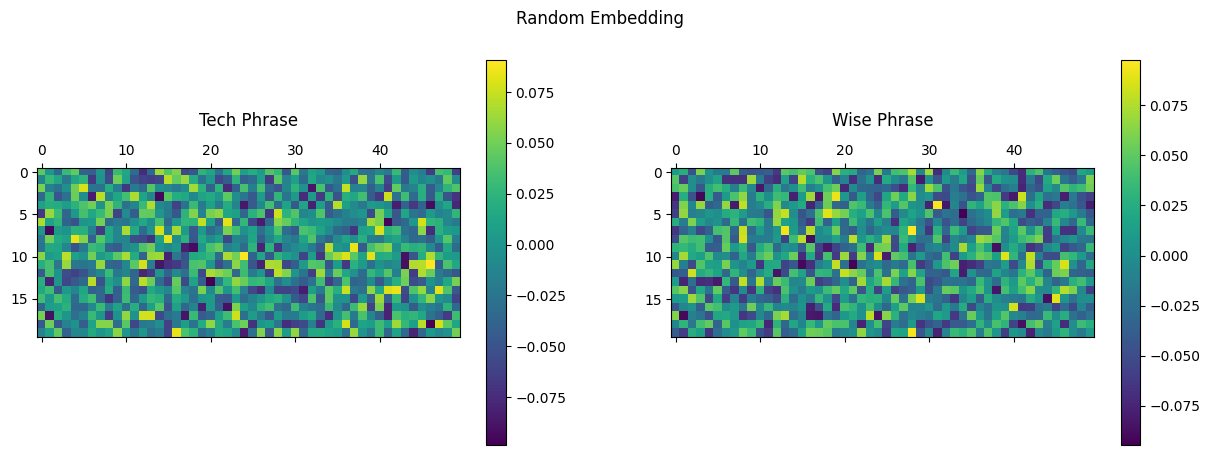

In [14]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

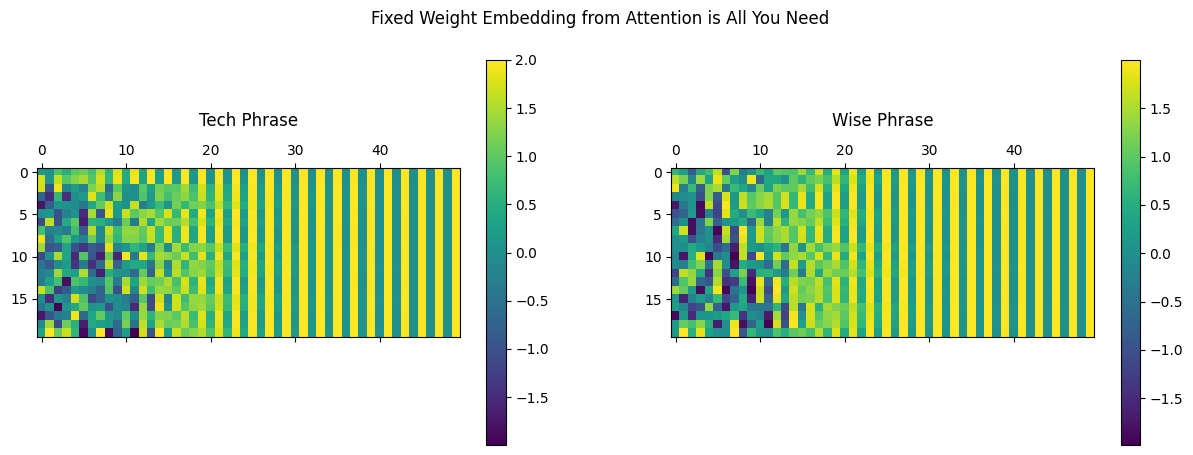

In [15]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

## Encoder
- https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/

In [16]:
class AddNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = tf.keras.layers.LayerNormalization() 

    def call(self, x, sublayer_x):
        add = x + sublayer_x
        return self.layer_norm(add)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = tf.keras.layers.Dense(d_ff)
        self.fully_connected2 = tf.keras.layers.Dense(d_model)
        self.activation = tf.keras.layers.ReLU()

    def call(self, x):
        x_fc1 = self.fully_connected1(x)
        return self.fully_connected2(self.activation(x_fc1))

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training):
        multihead_output = self.multihead_attention(x, x, x, padding_mask) # output: (batch_size, sequence_length, d_model)
        multihead_output = self.dropout1(multihead_output, training=training)
        addnorm_output = self.add_norm1(x, multihead_output)  # output: (batch_size, sequence_length, d_model)
        feedforward_output = self.feed_forward(addnorm_output)  # output: (batch_size, sequence_length, d_model)
        feedforward_output = self.dropout2(feedforward_output, training=training)
        return self.add_norm2(addnorm_output, feedforward_output)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, input_sentence, padding_mask, training):
        pos_encoding_output = self.pos_encoding(input_sentence)  # output: (batch_size, sequence_length, d_model)
        x = self.dropout(pos_encoding_output, training=training)
        for layer in self.encoder_layer: # Pass on the positional encoded values to each encoder layer
            x = layer(x, padding_mask, training)
        return x

In [17]:
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
enc_vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
input_seq = np.random.random((batch_size, input_seq_length))
encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(encoder(input_seq, None, True).shape)

(64, 5, 512)


## Decoder

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        self.add_norm3 = AddNormalization()

    def call(self, x, encoder_output, lookahead_mask, padding_mask, training):
        multihead_output1 = self.multihead_attention1(x, x, x, lookahead_mask) # output: (batch_size, sequence_length, d_model)
        multihead_output1 = self.dropout1(multihead_output1, training=training)
        addnorm_output1 = self.add_norm1(x, multihead_output1)
        multihead_output2 = self.multihead_attention2(addnorm_output1, encoder_output, encoder_output, padding_mask)
        multihead_output2 = self.dropout2(multihead_output2, training=training)
        addnorm_output2 = self.add_norm1(addnorm_output1, multihead_output2)
        feedforward_output = self.feed_forward(addnorm_output2) # output: (batch_size, sequence_length, d_model)
        feedforward_output = self.dropout3(feedforward_output, training=training)
        return self.add_norm3(addnorm_output2, feedforward_output)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.decoder_layer = [DecoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):
        pos_encoding_output = self.pos_encoding(output_target) # output: (number of sentences, sequence_length, d_model)
        x = self.dropout(pos_encoding_output, training=training)
        for layer in self.decoder_layer: # Pass on the positional encoded values to each encoder layer
            x = layer(x, encoder_output, lookahead_mask, padding_mask, training)
        return x

In [19]:
dec_vocab_size = 20  # Vocabulary size for the decoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the decoder stack
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
input_seq = np.random.random((batch_size, input_seq_length))
enc_output = np.random.random((batch_size, input_seq_length, d_model))
decoder = Decoder(dec_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(decoder(input_seq, enc_output, None, True).shape)

(64, 5, 512)


## Transformer with masking

In [20]:
class TransformerModel(tf.keras.models.Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)
        self.model_last_layer = tf.keras.layers.Dense(dec_vocab_size)

    def padding_mask(self, input):
        mask = tf.math.equal(input, 0) # Create mask which marks the zero padding values in the input by a 1.0
        mask = tf.cast(mask, tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :] # The shape of the mask should be broadcastable to the shape of the attention weights that it will be masking later on

    def lookahead_mask(self, shape):
        mask = 1 - tf.linalg.band_part(tf.ones((shape, shape)), -1, 0) # Mask out future entries by marking them with a 1.0
        return mask

    def call(self, encoder_input, decoder_input, training):
        enc_padding_mask = self.padding_mask(encoder_input)  # Create padding mask to mask the encoder inputs and the encoder outputs in the decoder
        # Create and combine padding and look-ahead masks to be fed into the decoder
        dec_in_padding_mask = self.padding_mask(decoder_input)
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        dec_in_lookahead_mask = tf.maximum(dec_in_padding_mask, dec_in_lookahead_mask)
        encoder_output = self.encoder(encoder_input, enc_padding_mask, training)
        decoder_output = self.decoder(decoder_input, encoder_output, dec_in_lookahead_mask, enc_padding_mask, training)
        model_output = self.model_last_layer(decoder_output)
        return model_output

In [27]:
enc_vocab_size = 20 # Vocabulary size for the encoder
dec_vocab_size = 20 # Vocabulary size for the decoder
enc_seq_length = 5  # Maximum length of the input sequence
dec_seq_length = 5  # Maximum length of the target sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(training_model)